# Impactor trajectory analysis with Lambert problem

Yuri Shimane

2024/08/22

In [1]:
import numpy as np
import pykep as pk
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from numba import njit

In [2]:
import numbers

def get_lc_traj_singleColor(xs, ys, cs, vmin, vmax, cmap, lw=0.8):
    """
    Get line collection object for a trajectory with a single color based on a colormap defined by vmin ~ vmax

    For plotting, run:
        line = ax.add_collection(lc)
        fig.colorbar(line, ax=ax, label="Colorbar label")

    Args:
        xs (np.array): array-like object of x-coordinates of the trajectory
        ys (np.array): array-like object of y-coordinates of the trajectory
        cs (float or np.array): float or array-like object of color-values along the coordinates
        vmin (float): minimum bound on colorbar
        vmax (float): maximum bound on colorbar
        cmap (str): colormap, e.g. 'viridis'
        lw (float): linewidth of trajectory

    Returns:
        (obj): line collection object
    """
    # check if cs is a float, and if it is convert it to an array
    if isinstance(cs, numbers.Real) == True:
    	cs = cs * np.ones((len(xs),))

    # generate segments
    points = np.array([ xs , ys ]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    plt_color = cs

    # create color bar
    norm = plt.Normalize( vmin, vmax )
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    # Set the values used for colormapping
    lc.set_array( plt_color )
    lc.set_linewidth( lw )
    return lc

In [3]:
MU_MOON = 4902.8001            # km^3/s^2
LU = 1737.4                    # km
VU = np.sqrt(MU_MOON/LU)       # km/s
TU = LU/VU                     # sec
R_MOON = 1737.4                # km

mu = 1.0

In [4]:
@njit
def get_rv_perifocal(mu, rp, ra, theta):
    """Compute r and v vectors in perifocal frame"""
    # compute orbital shape parameters
    e = (ra-rp)/(ra+rp)                # eccentricity
    a = rp / (1-e)                     # semimajor axis
    vp = np.sqrt(mu*(2/rp - 1/a))      # periapsis speed
    h = rp * vp                        # angular momentum
    # compute r and v vectors in perifocal frame
    ct = np.cos(theta)
    st = np.sin(theta)
    rPF = h**2/(mu*(1+e*ct)) * np.array([ct, st, 0.0])
    vPF = mu/h * np.array([-st, e+ct, 0.0])
    return rPF,vPF

In [5]:
get_rv_perifocal(1.0, 1.01, 2.1, 0.34)

(array([0.96654166, 0.34190143, 0.        ]),
 array([-0.28554456,  1.10731958,  0.        ]))

In [6]:
def acos_safe(theta):
    return np.arccos(max(-1, min(theta, 1)))

In [7]:
def get_impactor_transfer(mu, rp, ra, theta_dep, r_surface, verbose=False):
    """Get impactor transfer by solving Lambert problem"""
    assert theta_dep > 0, "theta_dep must be larger than 0"
    # get initial and final positions
    r1, v1 = get_rv_perifocal(mu, rp, ra, theta_dep)
    r2 = np.array([r_surface, 0.0, 0.0])

    # transfer time
    e = (ra-rp)/(ra+rp)                # eccentricity
    a = (rp+ra)/2                      # semimajor axis
    period = 2*np.pi*np.sqrt(a**3/mu)
    E0 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(theta_dep/2))
    M0 = E0 - e*np.sin(E0)
    if M0 < 0:
        M0 = 2*np.pi + M0
    t0 = M0/(2*np.pi) * period
    tof = period - t0

    # solve Lambert problem
    l = pk.lambert_problem(r1, r2, tof, mu=mu, cw=False, max_revs=0)
    v1_lamb = l.get_v1()[0]
    v2_lamb = l.get_v2()[0]
    DV1 = v1_lamb - v1                 # transfer delta-V

    # compute aop of transfer
    energy_transfer = np.linalg.norm(v1_lamb)**2/2 - mu/np.linalg.norm(r1)
    a_transfer = -mu/(2*energy_transfer)
    hvec = np.cross(r1, v1_lamb)
    h_transfer = np.linalg.norm(hvec)
    evec = np.cross(v1_lamb,hvec)/mu - r1/np.linalg.norm(r1)
    e_transfer = np.linalg.norm(evec)
    rp_transfer = a_transfer * (1 - e_transfer)
    aop_transfer = np.arccos(evec[0]/e_transfer)
    if evec[1] < 0:
        aop_transfer *= -1
    valid = aop_transfer >= 0.0
    rp_vec_transfer = rp_transfer * np.array([np.cos(aop_transfer), np.sin(aop_transfer)])

    # print message
    if verbose:
        print(f"Transfer location M0 = {np.rad2deg(M0):1.3f} deg")
        print(f"Transfer time = {tof:1.4f} ({tof/period:1.4f} of period)")
    return r1, v1_lamb, v2_lamb, DV1, tof, rp_vec_transfer, valid

In [8]:
get_impactor_transfer(mu, 1.1, 3.0, np.deg2rad(170), 1.0)

(array([-2.91616154,  0.51419796,  0.        ]),
 (-0.15416609727006644, -0.3931930962740776, 0.0),
 (-0.012514989294529218, 1.2258864766304296, 0.0),
 array([-0.01730179,  0.01775338,  0.        ]),
 10.448396961054673,
 array([0.99937918, 0.03049424]),
 True)

In [9]:
def get_transfer_history(mu,r0,v0,tof,steps=100):
    rs, vs = np.zeros((3,steps)), np.zeros((3,steps))
    times = np.linspace(0.0, tof,steps)
    for idx,t in enumerate(times):
        rs[:,idx], vs[:,idx] = pk.propagate_lagrangian(r0=r0, v0=v0, tof=t, mu=mu)
    return rs, vs

In [10]:
def plot_circle(center, radius, ax, steps=100, color='k', linewidth=0.5):
    thetas = np.linspace(0.0, 2*np.pi, steps)
    rs = np.zeros((2,steps))
    for idx,theta in enumerate(thetas):
        rs[:,idx] = np.array([center[0] + radius*np.cos(theta), center[1] + radius*np.sin(theta)])
    ax.plot(rs[0,:], rs[1,:], color=color, linewidth=linewidth)
    return

In [11]:
def plot_perifocal_orbit(mu, rp, ra, steps=100, ax=None, color='dodgerblue', linewidth=0.5):
    thetas = np.linspace(0.0, 2*np.pi, steps)
    rs = np.zeros((3,steps))
    for idx,theta in enumerate(thetas):
        rs[:,idx],_ = get_rv_perifocal(mu, rp, ra, theta)
    if ax is not None:
        ax.plot(rs[0,:], rs[1,:], color=color, linewidth=linewidth)
    return rs

In [30]:
# get impactor trajectory
rp = (1737.4 + 20) / LU
ra = (1737.4 + 50000) / LU
r1, v1_lamb, v2_lamb, DV1, tof, rp_vec_transfer, valid = get_impactor_transfer(mu, rp, ra, np.deg2rad(140), 1.0)
rs_impactor, _ = get_transfer_history(mu,r1,v1_lamb,tof,steps=100)

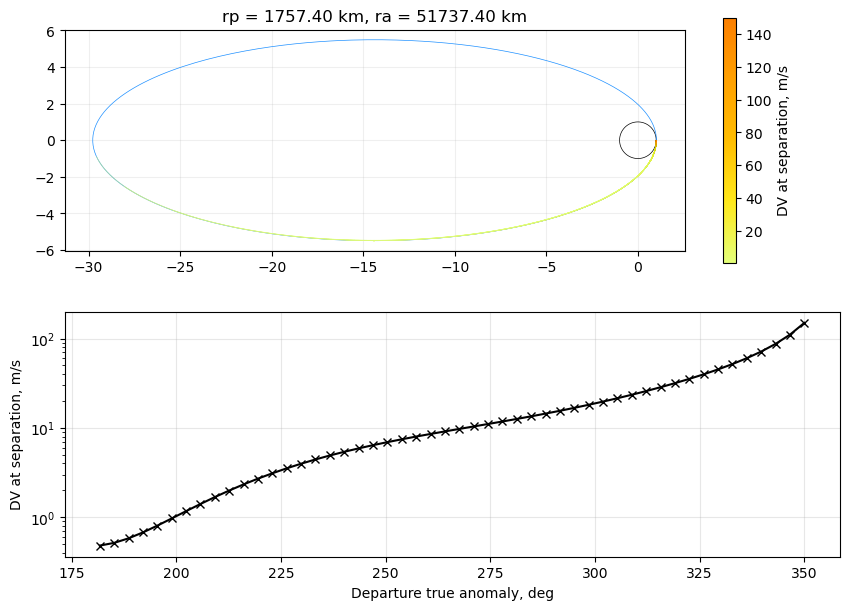

In [32]:
fig, axs = plt.subplots(2,1,figsize=(10,7))
# plot transfer
ax = axs[0]
ax.grid(True, alpha=0.2)
plot_circle([0,0], 1.0, ax)
steps = 1000
plot_perifocal_orbit(mu, rp, ra, ax=ax, steps=steps)

theta_dep_valid, rs_list, costs_dv = [], [], []
for theta_dep in np.linspace(10,350,100):
    r1, v1_lamb, v2_lamb, DV1, tof, rp_vec_transfer, valid = get_impactor_transfer(
        mu, rp, ra, np.deg2rad(theta_dep), r_surface=1.0
    )
    if valid:
        rs_impactor, _ = get_transfer_history(mu,r1,v1_lamb,tof,steps=steps)
        theta_dep_valid.append( theta_dep )
        rs_list.append( rs_impactor )
        costs_dv.append( np.linalg.norm(DV1) * VU * 1e3 )

for rs,cost in zip(rs_list, costs_dv):
    lc = get_lc_traj_singleColor(rs[0,:], rs[1,:], cost, min(costs_dv), max(costs_dv), "Wistia", lw=0.4)
    line = ax.add_collection(lc)
fig.colorbar(line, ax=ax, label="DV at separation, m/s")
ax.set_title(f"rp = {rp*LU:1.2f} km, ra = {ra*LU:1.2f} km")    
ax.set_aspect('equal')

ax = axs[1]
ax.grid(True, alpha=0.3)
ax.semilogy(theta_dep_valid, costs_dv, marker="x", color="k")
ax.set(xlabel="Departure true anomaly, deg", ylabel="DV at separation, m/s")
plt.show()